# Visualize Accuracy Schedule
This notebook visualizes variables related to the accuracy schedule in [Bayesian Flow Networks (Graves et al. 2023)](https://arxiv.org/pdf/2308.07037.pdf).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import torch

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
from bfn.bayesian_flow_networks import compute_alpha_continuous, compute_beta, compute_gamma, compute_entropy
from bfn.plotting_utils import get_next_color

## Plotting Code

In [3]:
def plot_schedule(t_values, alpha, beta, gamma, entropy, rho, var):
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

  color_gen = get_next_color(plt.cm.tab10)

  # plot alpha
  color = next(color_gen)
  axs[0, 0].plot(t_values, alpha, color=color)
  axs[0, 0].set_title('$\\alpha$')
  log_alpha_ax = axs[0, 0].twinx()
  log_alpha_ax.plot(t_values, alpha, color=color, linestyle='dashed', alpha=0.5, label='log scale')
  log_alpha_ax.set_yscale('log')
  log_alpha_ax.legend()

  # plot beta
  color = next(color_gen)
  axs[0, 1].plot(t_values, beta, color=color)
  axs[0, 1].set_title('$\\beta$')
  log_beta_ax = axs[0, 1].twinx()
  log_beta_ax.plot(t_values, beta, color=color, linestyle='dashed', alpha=0.5, label='log scale')
  log_beta_ax.set_yscale('log')
  log_beta_ax.legend()

  # plot gamma
  color = next(color_gen)
  axs[0, 2].plot(t_values, gamma, color=color)
  axs[0, 2].set_title('$\\gamma$')

  # plot entropy
  axs[1, 0].plot(t_values, entropy, color=next(color_gen))
  axs[1, 0].set_title('$H$')

  # plot rho
  color = next(color_gen)
  axs[1, 1].plot(t_values, rho, color=color)
  axs[1, 1].set_title('$\\rho$')
  log_rho_ax = axs[1, 1].twinx()
  log_rho_ax.plot(t_values, rho, color=color, linestyle='dashed', alpha=0.5, label='log scale')
  log_rho_ax.set_yscale('log')
  log_rho_ax.legend()

  # plot variance
  axs[1, 2].plot(t_values, var, color=next(color_gen), label='variance')
  axs[1, 2].plot(t_values, var**0.5, color=next(color_gen), label='std')
  axs[1, 2].set_title('Variance and STD of Bayesian flow distribution $p_F(\\cdot | \mathbf{x}; t)$')
  axs[1, 2].legend()

  [ax.set_xlabel('Time $t$') for ax in axs.flatten()]

  plt.tight_layout()

## Visualize accuracy schedule for continuous 
The training process of Bayesian flow networks involves an iterative transmission process whereby samples $\mathbf{y}$ from the sender distribution $p_S(\mathbf{y} | \mathbf{x}; \alpha)$ are used to update the parameters $\bm{\theta}$ of the input data distribution $p_I(\mathbf{x}| \bm{\theta})$ via Bayes rule. The _accuracy rate_ $\alpha$ is the precision (inverse variance) of the sender distribution $p_S(\mathbf{y} | \mathbf{x}; \alpha)$.

The goal is to define a transmission process over time $t \in [0, 1]$ via a function $\alpha(t)$ such that "when $\alpha = 0$, sender samples are entirely uninformative about $\mathbf{x}$ and as $\alpha$ increases the samples become progressively more informative" (_Section 3.1_).

To do this, we define the _accuracy schedule_ $\beta(t)$ as
\begin{align}
\beta(t) = \int_{t'=0}^t \alpha(t')dt', \tag{9}
\end{align}
and defines the entropy $H(t)$ of the input distribution over the transmission proces as a function of $\beta(t)$:
\begin{align}
H(t) &:= \mathbb{E}_{p_F(\bm{\theta} | \mathbf{x}; t)} H(p_I(\cdot | \bm{\theta})) \tag{64} \\
&=\frac{D}{2} \ln \left(\frac{2\pi e}{1 + \beta(t)}\right), \tag{65}
\end{align}
where $p_F(\bm{\theta} | \mathbf{x}; t)$ is the marginal distribution over parameters $\bm{\theta}$ at time $t$ of the transmission process.

With this relationship between $\alpha(t)$, $\beta(t)$, and $H(t)$, we can design the transmission process such that information flows into the input distribution at a constant rate by requiring $H(t)$ to linearly decrease with $t$:
\begin{align}
H(t) = (1-t)H(0) + tH(1), \tag{66}
\end{align}
which produces the identity
\begin{align}
(1 + \beta(t))^{-1} = (1 + \beta(1))^{-t}, \tag{69}
\end{align}
which implies that the entire schedule of $\alpha(t)$, $\beta(t)$, and $H(t)$ depends on the value of $\beta(1)$.

The value of $\beta(1)$ in turn can be derived from the choice of $\sigma_1$, the desired standard deviation of the input distribution at $t=1$ which is chosen as a hyperparameter, as:
\begin{align}
\beta(t) = \sigma_1^{-2t} - 1 \tag{72}.
\end{align}
This derivation is covered in the following subsection.

Having instantiated the accuracy schedule $\beta(t)$, the Bayesian flow distribution $p_F(\bm{\theta} | \mathbf{x}; t)$ can be calculated as a normal distribution with mean $\gamma(t)\mathbf{x}$ and variance $\gamma(t)(1-\gamma(t))\mathbf{I}$, where
\begin{align}
\gamma(t) &:= \frac{\beta(t)}{1+\beta(t)} \tag{78} \\
&= 1- \sigma_1^{2t}.
\end{align}
How this parameterization of the Bayesian flow distribution is derived can be found in _Section 4.6_.




### Deriving $\beta(1)$ from $\sigma_1$
The value of $\beta(1)$ can be derived from the choice of $\sigma_1$, the desired standard deviation of the input distribution at $t=1$ which is chosen as a hyperparameter, as:
\begin{align}
\beta(t) = \sigma_1^{-2t} - 1 \tag{72}.
\end{align}
The derivation works as follows. Recalling that the parameters $\bm{\theta}$ of the input distribution are $\{\mu, \rho\}$, the standard deviation $\sigma_1$ is the inverse square root of the precision $\rho_1$ at time $t=1$. We know from the Bayesian update function that during a step of transmission with accuracy rate $\alpha$ the previous $\rho_{i-1}$ is updated to $\rho_i$ as
\begin{align}
\rho_i = \rho_{i-1} + \alpha. \tag{49}
\end{align}
We also know that for Gaussian variables such updates are additive (_Section 4.4_) in the sense that
\begin{align}
\rho_{i+k} = \rho_{i} + \sum_{j=i}^{i+k} \alpha_j. \notag
\end{align}
where $k$ is the number of transmission steps after step $i$.
Or, in continuous time, this additivity translates to
\begin{align}
\rho(i+t) = \rho(i) + \int_{t'=i}^{i+t} \alpha(t') dt', \notag
\end{align}
where $t$ is the amount of time that has passed after time $i$.
with continuous time. Applying this relationship to the initial $\rho(0)$ gives us
\begin{align}
\rho(t) &= \rho(0) + \int_{t'=0}^{t} \alpha(t') dt' \notag \\
&= \rho(0) + \beta(t) \notag
\end{align}
Then, with the choice of unit precision for the initial parameters $\rho(0) = 1$, we arrive at the relationship $\rho(t) = 1 + \beta(t)$, which when combined with the definition that $\sigma^2 = \rho^{-1}$, gives us
\begin{align}
\beta(t) = \sigma_1^{-2t} - 1 \tag{72}
\end{align}
as required.

In [4]:
D = 1
intervals = 100

t_lo, t_hi = 0, 1
x_lo, x_hi = -2, 2
t_values = torch.linspace(t_lo, t_hi, intervals)

sigma_1 = torch.tensor(0.02)
alpha = compute_alpha_continuous(sigma_1, t_values)
beta = compute_beta(sigma_1, t_values)
gamma = compute_gamma(sigma_1, t_values)
entropy = compute_entropy(beta, D)
rho = 1 + beta
var = gamma * (1-gamma)

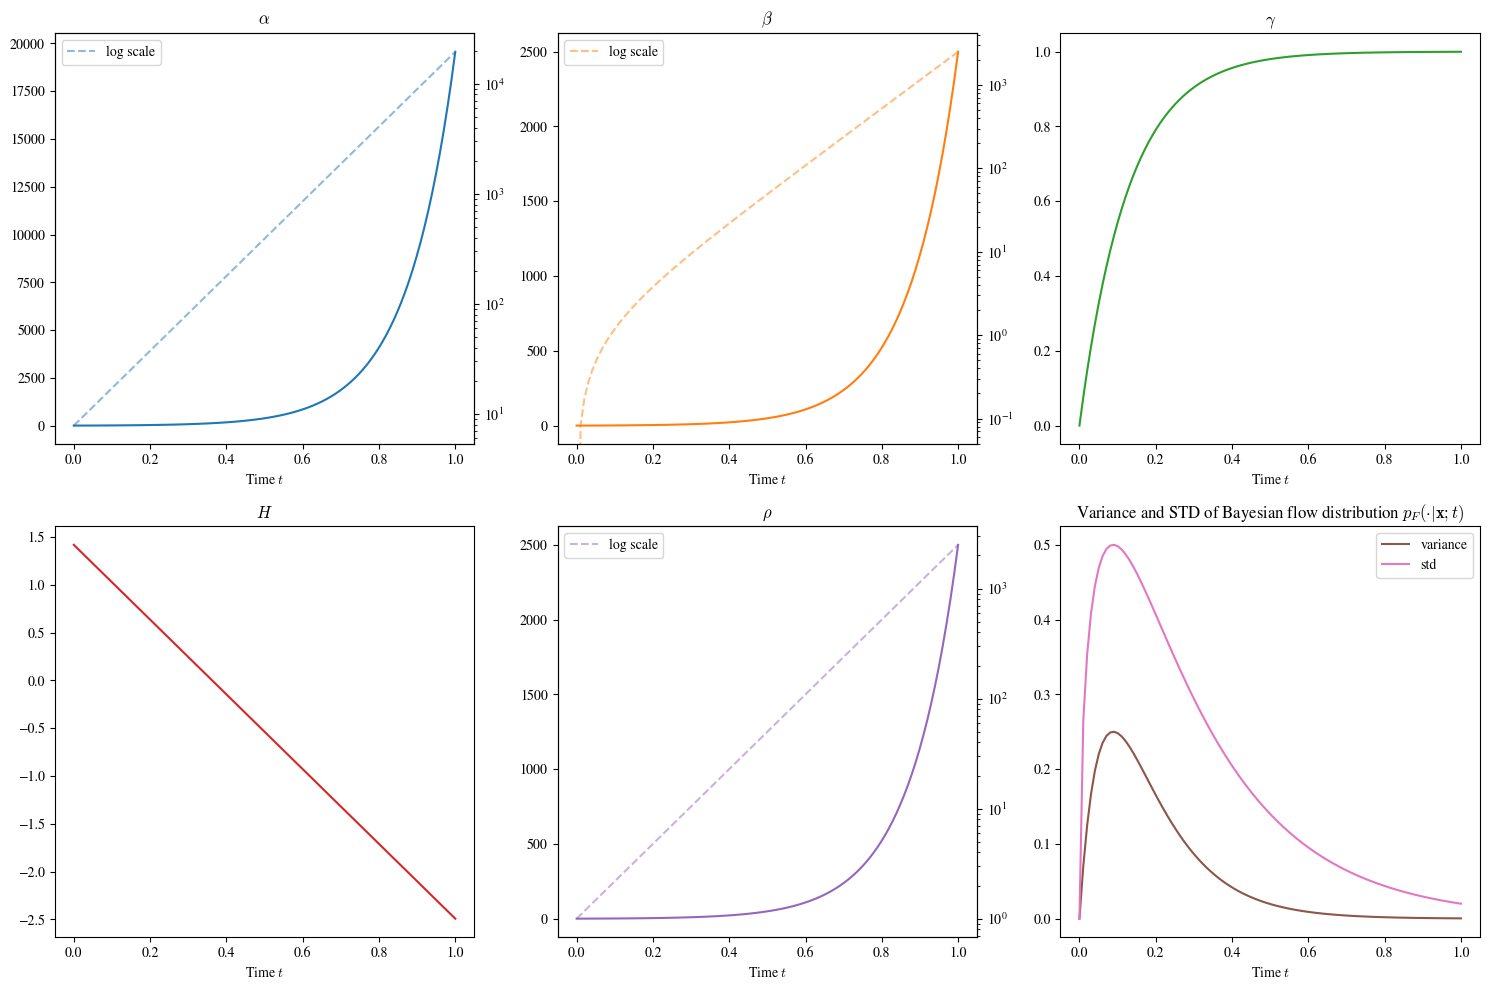

In [5]:
plot_schedule(t_values, alpha, beta, gamma, entropy, rho, var)

The plots above depend on the choice of $\sigma_1 = 0.02$ and initial $\rho(0) = 1$. As we can see, $H$ linearly decreases over time, and $\alpha$, $\beta$, and $\gamma$ follow exponential curves. As time increases, both the precision $\alpha$ of the sender distribution and the precision $\rho$ of the input distribution increase exponentially by construction. The variance of the Bayesian flow distribution initially increases and then gradually decreases.

## Verify that integrating $\alpha$ gives you $\beta$

Both $\alpha(t)$ and $\beta(t)$ are implemented as a function of $\sigma_1$, so this plot verifies the relationship that 
\begin{align}
\beta(t) = \int_{t'=0}^t \alpha(t')dt'. \tag{9}
\end{align}

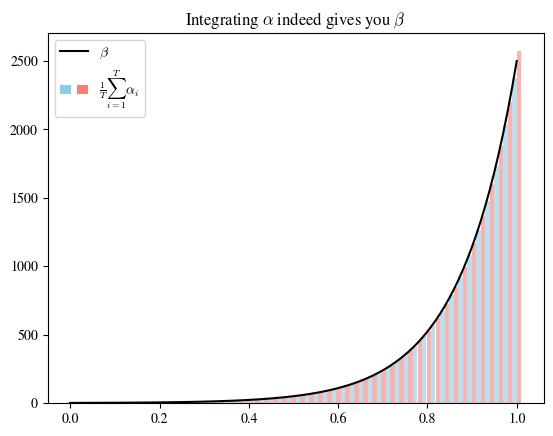

In [6]:
# Plot beta using a line
plt.plot(t_values, beta, label='$\\beta$', color='black')

# Compute the cumsum
cumsum_alpha = torch.cumsum(alpha * 1/intervals, 0)

# Create the bars with alternating colors
bar_width = (t_hi - t_lo) / intervals
colors = ['skyblue', 'salmon']
for idx, (t, height) in enumerate(zip(t_values, cumsum_alpha)):
    plt.bar(t, height, width=bar_width, align='edge', color=colors[idx % 2], alpha=0.6)

# Custom legend
red_patch = mpatches.Patch(facecolor=colors[0])
blue_patch = mpatches.Patch(facecolor=colors[1])

# Create a custom legend using legend elements
legend_elements = [Line2D([0], [0], color='black', label='$\\beta$'),
                tuple([red_patch, blue_patch])]

plt.legend(
    handles=legend_elements,
    labels=['$\\beta$', '$\\frac{1}{T}\sum_{i=1}^T \\alpha_i$'],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='upper left')

plt.title('Integrating $\\alpha$ indeed gives you $\\beta$')
plt.show()